In [1]:
import sys
parentdir = "../.."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 101.0.4951
[WDM] - Get LATEST driver version for 101.0.4951
[WDM] - Driver [/Users/gaignard-a/.wdm/drivers/chromedriver/mac64/101.0.4951.41/chromedriver] found in cache


In [2]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

In [3]:
TIMEOUT = (10, 300)
#NB = 500
NB = 10
OUTPUT_DIR = "../results/dryad_data/"

def dryadRequest(url):
    print("REST request to dryad...")
    # rest request
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except requests.exceptions.SSLError:
            print("Error, retrying...")
            time.sleep(5)
        except requests.exceptions.Timeout:
            print("Timeout error, retrying...")
            time.sleep(5)

    return response

def dryadParser(response):
    print("Parsing result...")
    json_response = response.json()
    next_page = "https://datadryad.org" + json_response["_links"]["next"]["href"]
    count_step = int(json_response["count"])
    print(next_page)

    
    dois_list = []
    count = 0
    while True:
        for element in json_response["_embedded"]["stash:datasets"]:
            identifier = element["identifier"].replace("doi:", "https://doi.org/")
            dois_list.append(identifier)

        count += count_step
        if count > NB:
            break
        response = dryadRequest(next_page)
        json_response = response.json()
        next_page = "https://datadryad.org" + json_response["_links"]["next"]["href"]
        print(next_page)
        

    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list
    

In [4]:
response = dryadRequest("https://datadryad.org/api/v2/datasets?per_page=100")
dois_list = dryadParser(response)
print(len(dois_list))

REST request to dryad...
Parsing result...
https://datadryad.org/api/v2/datasets?page=2&per_page=100
Retrieved 100 DOIs
100


In [5]:
import random

random.seed(10)

samples_dois_list = random.sample(dois_list, NB)

splitedSize = 100
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [6]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
metrics_collection.append(FAIRMetricsFactory.get_I1(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))

df_columns = ['ID']
for m in metrics_collection:
    df_columns.append(m.get_principle_tag())

In [7]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time


In [8]:
def mass_eval(samples):
    evals = []
    exec_time = []

    for sample in tqdm(samples):
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
        
    
    return evals, exec_time

In [9]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv(OUTPUT_DIR + "FC_results_DRYAD_data_"+str(i)+".csv")
    df_time.to_csv(OUTPUT_DIR + "exec_time_DRYAD_data_"+str(i)+".csv")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

http://schema.org


INFO:cdeb3498-154c-4a18-9b72-112be9f12dae:Checking if the URL is reachable, status code: 200
INFO:cdeb3498-154c-4a18-9b72-112be9f12dae:Status code is OK, meaning the url is Unique.
INFO:4a10a8c8-4ef3-4b16-abd5-961a603e372b:Strong evaluation:
INFO:4a10a8c8-4ef3-4b16-abd5-961a603e372b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4a10a8c8-4ef3-4b16-abd5-961a603e372b:Found at least one of those property in metadata
INFO:d934dd21-e6fe-4b0b-8b3d-51fb2ae22f6e:Checking if data is structured, looking for at least one RDF triple...
INFO:d934dd21-e6fe-4b0b-8b3d-51fb2ae22f6e:125 RDF triples were found, thus data is in a well structured graph format
INFO:eb4b1a24-0ed0-4854-a858-e3bb20c9b883:Checking if data is structured, looking for at least one RDF triple...
INFO:eb4b1a24-0ed0-4854-a858-e3bb20c9b883:125 RDF triples were found, thus data is in a well structured graph format
INFO:7ddcd82a-7311-4b4a-ac64-7faf09b952d4:Checking that at least 3 different URL

http://schema.org


INFO:f71a5be7-9068-4515-b7c0-726cafdca3ac:Checking if the URL is reachable, status code: 200
INFO:f71a5be7-9068-4515-b7c0-726cafdca3ac:Status code is OK, meaning the url is Unique.
INFO:d52762f5-7a38-498b-bfc9-579b3e17cabd:Strong evaluation:
INFO:d52762f5-7a38-498b-bfc9-579b3e17cabd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d52762f5-7a38-498b-bfc9-579b3e17cabd:Found at least one of those property in metadata
INFO:80ee7eeb-bb68-4169-bce3-47a307e87c8b:Checking if data is structured, looking for at least one RDF triple...
INFO:80ee7eeb-bb68-4169-bce3-47a307e87c8b:96 RDF triples were found, thus data is in a well structured graph format
INFO:0ac5b88d-f1ec-42d1-b879-ef1c41c8d4ef:Checking if data is structured, looking for at least one RDF triple...
INFO:0ac5b88d-f1ec-42d1-b879-ef1c41c8d4ef:96 RDF triples were found, thus data is in a well structured graph format
INFO:b278460e-6aca-476d-993f-8bef8d1d9844:Checking that at least 3 different URL a

http://schema.org


INFO:91727fd1-c277-4899-b125-dc7f63886620:Checking if the URL is reachable, status code: 200
INFO:91727fd1-c277-4899-b125-dc7f63886620:Status code is OK, meaning the url is Unique.
INFO:99cdf4d5-9623-431e-b0e5-015cc0ef6f57:Strong evaluation:
INFO:99cdf4d5-9623-431e-b0e5-015cc0ef6f57:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:99cdf4d5-9623-431e-b0e5-015cc0ef6f57:Found at least one of those property in metadata
INFO:a8327bd1-b1fa-4692-9d70-77f766c10a01:Checking if data is structured, looking for at least one RDF triple...
INFO:a8327bd1-b1fa-4692-9d70-77f766c10a01:94 RDF triples were found, thus data is in a well structured graph format
INFO:3a098b8c-d418-4f4f-b82f-3fb1578f99e8:Checking if data is structured, looking for at least one RDF triple...
INFO:3a098b8c-d418-4f4f-b82f-3fb1578f99e8:94 RDF triples were found, thus data is in a well structured graph format
INFO:23ab3451-8530-4961-be77-feb3f409e909:Checking that at least 3 different URL a

http://schema.org


INFO:43d04e5e-c68c-4f85-a53e-91f74e6538cb:Checking if the URL is reachable, status code: 200
INFO:43d04e5e-c68c-4f85-a53e-91f74e6538cb:Status code is OK, meaning the url is Unique.
INFO:12d2b3f2-ba1c-41d4-a546-3c094d97d7ad:Strong evaluation:
INFO:12d2b3f2-ba1c-41d4-a546-3c094d97d7ad:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:12d2b3f2-ba1c-41d4-a546-3c094d97d7ad:Found at least one of those property in metadata
INFO:ffacca37-82c8-4d75-9a63-390525f91200:Checking if data is structured, looking for at least one RDF triple...
INFO:ffacca37-82c8-4d75-9a63-390525f91200:203 RDF triples were found, thus data is in a well structured graph format
INFO:cef366d3-4ace-41f5-9a43-ce1d5ef6ad66:Checking if data is structured, looking for at least one RDF triple...
INFO:cef366d3-4ace-41f5-9a43-ce1d5ef6ad66:203 RDF triples were found, thus data is in a well structured graph format
INFO:8bde0fc9-ecad-497b-a09f-1150d204a6b2:Checking that at least 3 different URL

http://schema.org


INFO:d0270fba-54ea-40aa-8373-bb5ac04810e8:Checking if the URL is reachable, status code: 200
INFO:d0270fba-54ea-40aa-8373-bb5ac04810e8:Status code is OK, meaning the url is Unique.
INFO:f1c0260a-6fc9-4a1c-a43e-212127cc40b6:Strong evaluation:
INFO:f1c0260a-6fc9-4a1c-a43e-212127cc40b6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f1c0260a-6fc9-4a1c-a43e-212127cc40b6:Found at least one of those property in metadata
INFO:0fd5c095-2073-4e06-a06c-95ee3b461111:Checking if data is structured, looking for at least one RDF triple...
INFO:0fd5c095-2073-4e06-a06c-95ee3b461111:72 RDF triples were found, thus data is in a well structured graph format
INFO:4ef87552-501c-4351-b3fc-f1f52a6ee459:Checking if data is structured, looking for at least one RDF triple...
INFO:4ef87552-501c-4351-b3fc-f1f52a6ee459:72 RDF triples were found, thus data is in a well structured graph format
INFO:7982a729-578c-49f0-93de-80746a3d7e9e:Checking that at least 3 different URL a

http://schema.org


INFO:c7458e0d-6b7f-4499-82e1-fa39b71635bb:Checking if the URL is reachable, status code: 200
INFO:c7458e0d-6b7f-4499-82e1-fa39b71635bb:Status code is OK, meaning the url is Unique.
INFO:8b8541ad-587b-46b5-a1fa-6454926a52d7:Strong evaluation:
INFO:8b8541ad-587b-46b5-a1fa-6454926a52d7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8b8541ad-587b-46b5-a1fa-6454926a52d7:Found at least one of those property in metadata
INFO:a2650d35-7c83-4b41-82a3-0382f4945030:Checking if data is structured, looking for at least one RDF triple...
INFO:a2650d35-7c83-4b41-82a3-0382f4945030:133 RDF triples were found, thus data is in a well structured graph format
INFO:cdc24577-b500-4b39-837f-1c5bfac4a822:Checking if data is structured, looking for at least one RDF triple...
INFO:cdc24577-b500-4b39-837f-1c5bfac4a822:133 RDF triples were found, thus data is in a well structured graph format
INFO:5561f666-5000-43f2-87ad-b3427104fb4d:Checking that at least 3 different URL

http://schema.org


INFO:f13adfe4-dec6-485b-a933-cbd07589fd86:Checking if the URL is reachable, status code: 200
INFO:f13adfe4-dec6-485b-a933-cbd07589fd86:Status code is OK, meaning the url is Unique.
INFO:3477a393-c9d2-4565-80ff-00fd81368428:Strong evaluation:
INFO:3477a393-c9d2-4565-80ff-00fd81368428:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3477a393-c9d2-4565-80ff-00fd81368428:Found at least one of those property in metadata
INFO:10690109-8dfc-4a73-9760-d90632228b79:Checking if data is structured, looking for at least one RDF triple...
INFO:10690109-8dfc-4a73-9760-d90632228b79:109 RDF triples were found, thus data is in a well structured graph format
INFO:c57623fb-3b1d-4c23-a94c-80ec9a233f10:Checking if data is structured, looking for at least one RDF triple...
INFO:c57623fb-3b1d-4c23-a94c-80ec9a233f10:109 RDF triples were found, thus data is in a well structured graph format
INFO:56580966-2442-4092-a9ec-918ceca05a32:Checking that at least 3 different URL

http://schema.org


INFO:c3f794d6-7df4-4487-a226-a1331ddc8608:Checking if the URL is reachable, status code: 200
INFO:c3f794d6-7df4-4487-a226-a1331ddc8608:Status code is OK, meaning the url is Unique.
INFO:c7596cf5-1ef8-4aad-b7a8-7363f05695b0:Strong evaluation:
INFO:c7596cf5-1ef8-4aad-b7a8-7363f05695b0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c7596cf5-1ef8-4aad-b7a8-7363f05695b0:Found at least one of those property in metadata
INFO:0e98cb32-300b-4afc-b949-db1ec909ff9b:Checking if data is structured, looking for at least one RDF triple...
INFO:0e98cb32-300b-4afc-b949-db1ec909ff9b:150 RDF triples were found, thus data is in a well structured graph format
INFO:25c565e8-0cd6-4c57-a364-59c10d6f31b1:Checking if data is structured, looking for at least one RDF triple...
INFO:25c565e8-0cd6-4c57-a364-59c10d6f31b1:150 RDF triples were found, thus data is in a well structured graph format
INFO:c6db5dea-2ce2-4b13-aa47-a0f3b8ac82ac:Checking that at least 3 different URL

http://schema.org


INFO:f592c330-9037-4de4-85af-be898f6423fe:Checking if the URL is reachable, status code: 200
INFO:f592c330-9037-4de4-85af-be898f6423fe:Status code is OK, meaning the url is Unique.
INFO:79e3eac7-6cd0-4245-a716-09ab23c5144a:Strong evaluation:
INFO:79e3eac7-6cd0-4245-a716-09ab23c5144a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:79e3eac7-6cd0-4245-a716-09ab23c5144a:Found at least one of those property in metadata
INFO:495e9a44-93d4-4d37-97c7-bfc42e1b01b6:Checking if data is structured, looking for at least one RDF triple...
INFO:495e9a44-93d4-4d37-97c7-bfc42e1b01b6:98 RDF triples were found, thus data is in a well structured graph format
INFO:c26869dd-2a30-4c1d-9138-14a65a34ff75:Checking if data is structured, looking for at least one RDF triple...
INFO:c26869dd-2a30-4c1d-9138-14a65a34ff75:98 RDF triples were found, thus data is in a well structured graph format
INFO:68a8c32d-7f32-4f08-9a88-bab04519afd3:Checking that at least 3 different URL a

http://schema.org


In [10]:
len(df)

10

In [11]:
df_time

,ID,F1A,F1B,F2A,I1,I3,R1.1,R1.2
0,https://doi.org/10.5061/dryad.ft58s,0.0,0.01,0.0,0.0,0.0,0.01,0.01
1,https://doi.org/10.5061/dryad.08vv50n,0.0,0.01,0.0,0.0,0.0,0.01,0.01
2,https://doi.org/10.5061/dryad.0s9j3,0.0,0.06,0.0,0.0,0.0,0.01,0.01
3,https://doi.org/10.5061/dryad.b26q1,0.0,0.01,0.0,0.0,0.0,0.01,0.01
4,https://doi.org/10.5061/dryad.r8d4q,0.0,0.01,0.0,0.0,0.0,0.01,0.01
5,https://doi.org/10.5061/dryad.mh67v,0.0,0.01,0.0,0.0,0.0,0.01,0.01
6,https://doi.org/10.5061/dryad.20r9k,0.0,0.01,0.0,0.0,0.0,0.01,0.01
7,https://doi.org/10.5061/dryad.mt048,0.0,0.01,0.0,0.0,0.0,0.01,0.01
8,https://doi.org/10.5061/dryad.216tp,0.0,0.01,0.0,0.0,0.0,0.01,0.01
9,https://doi.org/10.5061/dryad.r20t0,0.0,0.01,0.0,0.0,0.0,0.01,0.01


In [12]:
import glob

all_files = glob.glob(OUTPUT_DIR + "FC_results_DRYAD_data_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

In [14]:
from upsetplot import from_contents

F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]

I1 = df[((df["I1"].astype(int) > 0))]["ID"]

I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]

df_upset = from_contents({'F1B': F1B, 
                          'F2A': F2A, 
                          'I1': I1, 
                          'I3': I3, 
                          'R11': R11, 
                          'R12': R12,})
df_upset

id
F1B  F2A  I1   I3   R11  R12                                         
True True True True True False    https://doi.org/10.5061/dryad.ft58s
                         False  https://doi.org/10.5061/dryad.08vv50n
                         False    https://doi.org/10.5061/dryad.0s9j3
                         False    https://doi.org/10.5061/dryad.b26q1
                         False    https://doi.org/10.5061/dryad.r8d4q
                         False    https://doi.org/10.5061/dryad.mh67v
                         False    https://doi.org/10.5061/dryad.20r9k
                         False    https://doi.org/10.5061/dryad.mt048
                         False    https://doi.org/10.5061/dryad.216tp
                         False    https://doi.org/10.5061/dryad.r20t0

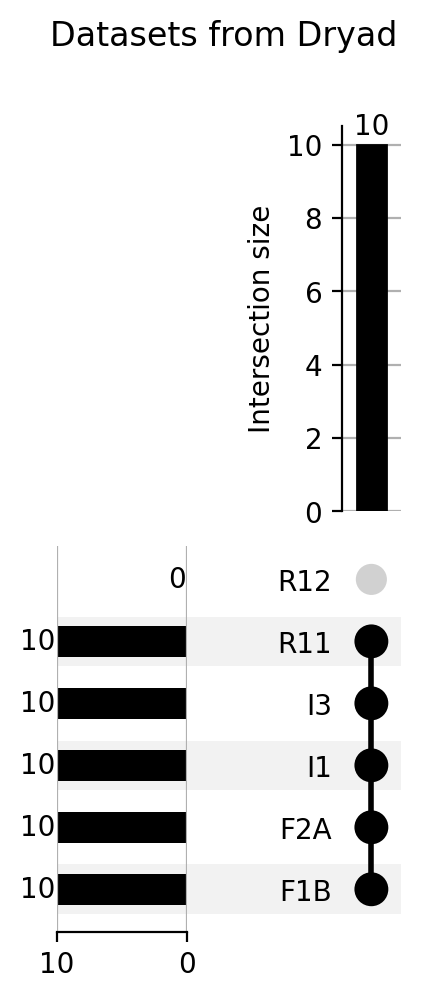

In [15]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Datasets from Dryad")
plt.savefig(OUTPUT_DIR + 'DRYAD-no-F2B-no-R13_data.png', format="png")
plt.show()